In [2]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from Bio import Phylo
from Bio.Cluster import treecluster
from Bio.Phylo import Consensus
import os
import ujson
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio import Phylo

In [3]:
def plot_dendrogram(distance_matrix, labels, linkage="single",
                    truncate_level=-1, figure_size=(20, 15),
                    dpi=300, savefig=False, fig_name="output.png"):
    
    cl = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',
                                 compute_full_tree=True, linkage=linkage, compute_distances=True)
    cl.fit(distance_matrix)
    
    kwarg = {"truncate_mode": "level", "p": truncate_level, "orientation": "right", "labels": labels}
    
    n_samples = len(cl.labels_)
    counts = np.zeros(cl.children_.shape[0])
    plt.figure(figsize=figure_size, dpi=dpi)
    for i, merge in enumerate(cl.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

        linkage_matrix = np.column_stack(
            [cl.children_, cl.distances_, counts]
        ).astype(float)
        dendrogram(linkage_matrix, **kwarg)
        pass
    
    if savefig is True:
        plt.savefig(fig_name)
        

In [19]:
def d1(similarity: np.ndarray, r: float) -> np.ndarray:
    ret = 1/np.power(r, similarity)
    np.fill_diagonal(ret, 0)
    return ret

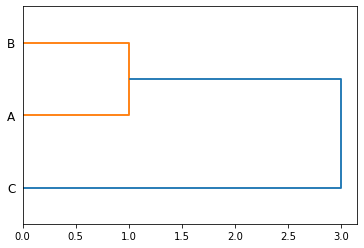

In [12]:
distance = np.array([[0, 1, 4],
                     [0, 0, 3],
                     [0, 0, 0]])
distance += distance.T
plot_dendrogram(distance, ['A', 'B', 'C'], figure_size=None, dpi=None)

In [6]:
cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',
                                 compute_full_tree=True, linkage="single", compute_distances=True)
cluster.fit(distance)
print(cluster.children_)
print(cluster.distances_)

NameError: name 'distance' is not defined

In [11]:
data_dir = "../data/"
f_collab_distance = os.path.join(data_dir, "collaboration_distances.csv")
df_collab_distance = pd.read_csv(f_collab_distance)
faculties = list(df_collab_distance.columns)    # Obtain a list of facauty names
faculties.pop(0)

'Unnamed: 0'

In [12]:
f_joint_pub = os.path.join(data_dir, "joint_publication.json")
with open(f_joint_pub) as file:
    d_joint_pub = ujson.load(file)

In [13]:
# Construct similarity matrix and distance matrix
num_ppl = len(faculties)
sim_joint_pub = np.zeros((num_ppl, num_ppl))
i = 0
j = 1
for key, val in d_joint_pub.items():
    sim_joint_pub[i, j] = val
    j += 1
    if j == num_ppl:
        i += 1
        j = i + 1
        pass
    pass

sim_joint_pub += sim_joint_pub.T
dist_joint_pub = 1 / np.power(1.5, sim_joint_pub)
np.fill_diagonal(dist_joint_pub, 0)

In [18]:
tree_joint_pub = treecluster(None, method="s", distancematrix=dist_joint_pub)

In [69]:
f_joint_cite = os.path.join(data_dir, "citation_joint.json")
with open(f_joint_cite) as file:
    d_joint_cite = ujson.load(file)

# Construct similarity matrix and distance matrix
num_ppl = len(faculties)
sim_joint_cite = np.zeros((num_ppl, num_ppl))
i = 0
j = 1
for key, val in d_joint_cite.items():
    sim_joint_cite[i, j] = val
    j += 1
    if j == num_ppl:
        i += 1
        j = i + 1
        pass
    pass

sim_joint_cite += sim_joint_cite.T
dist_joint_cite = d1(sim_joint_cite, 1.05)

In [72]:
tree_joint_cite = treecluster(None, method="s", distancematrix=dist_joint_cite)

In [73]:
constructor = DistanceTreeConstructor(distance_calculator=None, method='upgma')

In [74]:
dist_list_pub = []
for i in range(dist_joint_pub.shape[0]):
    nested = []
    for j in range(i + 1):
        nested.append(dist_joint_pub[i, j])
        pass
    
    dist_list_pub.append(nested)
    pass

phylo_dmatrix_joint = DistanceMatrix(faculties, matrix=dist_list_pub)
phylo_tree_joint = constructor.upgma(phylo_dmatrix_joint)

In [79]:
dist_list_cite = []
for i in range(dist_joint_pub.shape[0]):
    nested = []
    for j in range(i + 1):
        nested.append(dist_joint_cite[i, j])
        pass
    
    dist_list_cite.append(nested)
    pass

phylo_dmatrix_cite = DistanceMatrix(faculties, matrix=dist_list_cite)
phylo_tree_cite = constructor.upgma(phylo_dmatrix_cite)

In [80]:
Phylo.draw_ascii(phylo_tree_joint)

  ____________________________ Rosemary Guzman
 |
 |____________________________ Jeremiah  Heller
 |
 |____________________________ Richard S. Laugesen
 |
 |____________________________ Ely Kerman
 |
 |____________________________ Kay  Kirkpatrick
 |
 |____________________________ Felix Leditzky
 |
 |____________________________ Eduard-Wilhelm Kirr
 |
 |____________________________ William  Haboush
 |
 |                ____________ Xiaochen Jing
 |_______________|
 |               |____________ Runhuan Feng
 |
 |____________________________ James Pascaleff
 |
 |____________________________ Igor G. Nikolaev
 |
 |____________________________ Aimo  Hinkkanen
 |
 |____________________________ Partha Sarathi Dey
 |
 |____________________________ Jesse Thorner
 |
 |____________________________ Gabriele La Nave
 |
 |____________________________ Richard B. Sowers
 |
 |____________________________ Vesna Stojanoska
 |
 |                              __ Jared  Bronski
 |                  ________

In [81]:
Phylo.draw_ascii(phylo_tree_cite)

  _____________________________ Sankar P. Dutta
 |
 |_____________________________ Iwan M. Duursma
 |
 |_____________________________ Christopher  Dodd
 |
 | ____________________________ Gabriele La Nave
 ,|
 ||____________________________ Rosemary Guzman
 ||
 ||      ______________________ Steven  Bradlow
 ||_____|
 |      |______________________ Igor Mineyev
_|
 |  ____________________________ Ely Kerman
 |,|
 |||____________________________ James Pascaleff
 ||
 || _____________________________ William  Haboush
 |||
 ||| ____________________________ Jeremiah  Heller
 ||||
 ||||                ____________ Vesna Stojanoska
 ||||     __________|
 ||||    |          |           , Matthew Ando
 ||||____|          |___________|
 |||     |                      | Charles  Rezk
 | |     |
 | |     |_______________________ Randy McCarthy
 | |
 | |_____________________________ Daniel Berwick-Evans
 | |
 | |      _________________________ Alexander  Yong
 | |   __|
 | |  |  |                   

In [82]:
consensus_tree = Consensus.majority_consensus([phylo_tree_joint, phylo_tree_cite], cutoff=0.5)

In [1]:
Phylo.draw_ascii(consensus_tree)

NameError: name 'Phylo' is not defined